In [5]:
import pandas as pd
import os 

import numpy as np

In [14]:
def addEmails(filepath,label):
    emails = []
    for dirpath, dirnames, filenames in os.walk(filepath):
        for file in filenames:
            with open(os.path.join(filepath,file),"r",encoding = "utf-8",errors ="ignore") as f:
                content = f.read()
                emails.append({"text": content, "label" : label})
    return emails


In [15]:
spam = "./datasets/spam_2"
easy_ham = "./datasets/easy_ham"
hard_ham = "./datasets/hard_ham"

emails = []

emails += addEmails(spam,"spam")
emails += addEmails(easy_ham,"ham")
emails += addEmails(hard_ham,"ham")

In [25]:
df_emails = pd.DataFrame(emails)
df_emails

,text,label
0,From ilug-admin@linux.ie Tue Aug 6 11:51:02 ...,spam
1,From lmrn@mailexcite.com Mon Jun 24 17:03:24 ...,spam
2,From amknight@mailexcite.com Mon Jun 24 17:03...,spam
3,From jordan23@mailexcite.com Mon Jun 24 17:04...,spam
4,From merchantsworld2001@juno.com Tue Aug 6 1...,spam
...,...,...
2364,Return-Path: ler@lerami.lerctr.org\nDelivery-D...,ham
2365,Return-Path: ler@lerami.lerctr.org\nDelivery-D...,ham
2366,From bounce-ora_webprog-1083425@newsletter.ore...,ham
2367,Return-Path: linux-announce-recipients-owner-m...,ham


In [ ]:
df_emails[df_emails["text"].isna()]

,text,label


In [32]:
df_emails["label"].value_counts()

label
spam    1396
ham      973
Name: count, dtype: int64

In [33]:
from sklearn.model_selection import train_test_split
emails_train, emails_test = train_test_split(df_emails,test_size=0.2, stratify=df_emails["label"],random_state=42)

In [75]:
X_train = emails_train.drop("label",axis = 1)
y_train = emails_train["label"]
X_test = emails_test.drop("label", axis = 1)
y_test = emails_test["label"]

In [76]:
y_train = y_train == "spam"
y_test = y_test == "spam"

In [77]:
y_train

977      True
964      True
2148    False
1453    False
2269    False
        ...  
1780    False
1668    False
945      True
1841    False
104      True
Name: label, Length: 1895, dtype: bool

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin
import re
from nltk.stem import PorterStemmer

class EmailPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lowercase=True, remove_punct=True,
                 replace_urls=True, replace_numbers=True, stemming=False):
        self.strip_headers = strip_headers
        self.lowercase = lowercase
        self.remove_punct = remove_punct
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self._clean_text(text) for text in X]
    


    def _clean_text(self, text):
        t = text

        # 1. Remove headers
        if self.strip_headers:
            t = re.sub(r'^(.*?\n){0,10}', '', t)

        # 2. Replace URLs
        if self.replace_urls:
            t = re.sub(r'http\S+|www\S+', 'URL', t)

        # 3. Replace numbers
        if self.replace_numbers:
            t = re.sub(r'\d+', 'NUMBER', t)

        # 4. Stemming
        if self.stemming:
            words = re.findall(r'\b\w+\b', t.lower())
            t = " ".join(self.stemmer.stem(w) for w in words)

        return t


In [130]:
from sklearn.compose import ColumnTransformer,make_column_selector,make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict,cross_val_score,RandomizedSearchCV

model_pipeline = Pipeline(
    [
        ("prep",EmailPreprocessor()),
        ("vectorize", TfidfVectorizer(stop_words="english", max_features=20000, ngram_range=(1,2))),
        ("sgd", SGDClassifier(random_state=42))
    ]
)

 

In [ ]:
param_dist = {
    'sgd__loss': ['log_loss', 'hinge'],
    'sgd__penalty': ['l2', 'elasticnet'],
    'sgd__alpha': [1e-5, 1e-4, 1e-3],
    'sgd__learning_rate': ['optimal', 'adaptive']
    'prep__strip_headers': [True, False],
    'prep__lowercase': [True],  # usually keep True
    'prep__remove_punct': [True, False],
    'prep__replace_urls': [True, False],
    'prep__replace_numbers': [True, False],
    'prep__stemming': [True, False],
}



In [136]:
sgd_classifier = RandomizedSearchCV(model_pipeline,param_distributions=param_dist,n_iter=60,cv=3,scoring = "f1" )

In [137]:
sgd_classifier.fit(X_train["text"],y_train)

c:\Users\rafbl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
141 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rafbl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\rafbl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\rafbl\AppD

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'prep__remove_punct': [True, False], 'prep__replace_numbers': [True, False], 'prep__replace_urls': [True, False], 'prep__stemming': [True, False], ...}"
,n_iter,60
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [142]:
sgd_classifier.best_params_

{'sgd__penalty': 'elasticnet',
 'sgd__loss': 'log_loss',
 'sgd__learning_rate': 'optimal',
 'sgd__alpha': 1e-05,
 'prep__strip_headers': False,
 'prep__stemming': False,
 'prep__replace_urls': False,
 'prep__replace_numbers': False,
 'prep__remove_punct': False}

In [143]:
results = pd.DataFrame(sgd_classifier.cv_results_)

results.sort_values(by="mean_test_score",ascending=False, inplace=True)

results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgd__penalty,param_sgd__loss,param_sgd__learning_rate,param_sgd__alpha,param_prep__strip_headers,param_prep__stemming,param_prep__replace_urls,param_prep__replace_numbers,param_prep__remove_punct,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
58,4.614328,0.083717,1.579864,0.070455,elasticnet,log_loss,optimal,0.00001,False,False,False,False,False,"{'sgd__penalty': 'elasticnet', 'sgd__loss': 'l...",0.988079,0.988048,0.989362,0.988496,0.000612,1
54,4.184414,0.061042,1.324930,0.063753,l2,hinge,optimal,0.00010,True,False,False,False,True,"{'sgd__penalty': 'l2', 'sgd__loss': 'hinge', '...",0.985430,0.990679,0.989362,0.988490,0.002230,2
27,5.671103,0.972622,1.941074,0.631069,elasticnet,hinge,optimal,0.00010,False,False,True,True,True,"{'sgd__penalty': 'elasticnet', 'sgd__loss': 'h...",0.986772,0.992000,0.984085,0.987619,0.003286,3
51,5.218794,1.677662,1.868535,0.826784,elasticnet,hinge,optimal,0.00010,False,False,False,True,True,"{'sgd__penalty': 'elasticnet', 'sgd__loss': 'h...",0.984169,0.989362,0.988048,0.987193,0.002204,4
44,5.381844,0.893422,2.045632,0.383879,elasticnet,hinge,optimal,0.00010,False,False,False,True,False,"{'sgd__penalty': 'elasticnet', 'sgd__loss': 'h...",0.984169,0.989362,0.988048,0.987193,0.002204,4
37,4.561350,0.259903,1.493475,0.043936,elasticnet,log_loss,optimal,0.00010,False,False,True,False,True,"{'sgd__penalty': 'elasticnet', 'sgd__loss': 'l...",0.992021,0.984000,0.985392,0.987138,0.003500,6
40,4.768424,0.121376,1.702724,0.068944,elasticnet,log_loss,optimal,0.00001,False,False,True,True,False,"{'sgd__penalty': 'elasticnet', 'sgd__loss': 'l...",0.988079,0.988048,0.984085,0.986737,0.001876,7
11,4.431300,0.143227,1.724878,0.068993,l2,log_loss,optimal,0.00010,True,False,False,True,True,"{'sgd__penalty': 'l2', 'sgd__loss': 'log_loss'...",0.984169,0.985392,0.984127,0.984563,0.000587,8
28,4.723195,0.104743,1.744935,0.095054,elasticnet,log_loss,optimal,0.00010,False,False,True,True,True,"{'sgd__penalty': 'elasticnet', 'sgd__loss': 'l...",0.986772,0.980185,0.982781,0.983246,0.002709,9
1,4.492791,0.046785,1.874856,0.044501,l2,hinge,optimal,0.00100,False,False,True,True,True,"{'sgd__penalty': 'l2', 'sgd__loss': 'hinge', '...",0.986772,0.977602,0.982781,0.982385,0.003754,10


In [149]:

y_pred = cross_val_predict(sgd_classifier.best_estimator_,X_train["text"],y_train,cv=3)

In [150]:
report = classification_report(y_train,y_pred)
print(report)

              precision    recall  f1-score   support

       False       1.00      0.97      0.98       778
        True       0.98      1.00      0.99      1117

    accuracy                           0.99      1895
   macro avg       0.99      0.98      0.99      1895
weighted avg       0.99      0.99      0.99      1895



In [173]:
y_scores = cross_val_predict(sgd_classifier.best_estimator_,X_train["text"],y_train,cv=3,method = "decision_function")

In [174]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr,tpr,thresholds = roc_curve(y_train,y_scores)

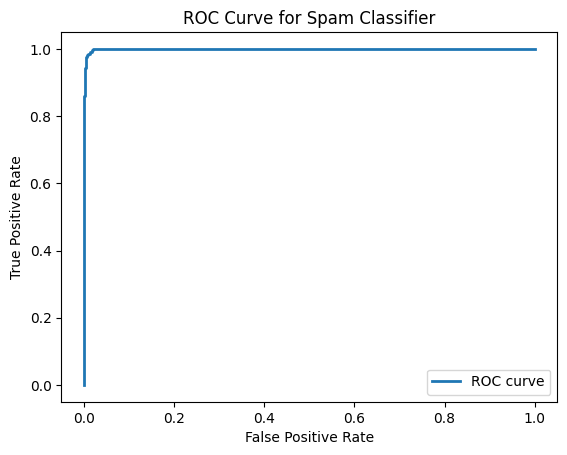

In [175]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Spam Classifier")
plt.legend()
plt.show()
 


In [176]:
# let's see if we can get a better ROC area under the curve so we can then choose the best threshold that will give us a very low fals pos rate 
roc_auc_score(y_train, y_scores)

0.9993038182977264

In [189]:
target_fpr = 0.006
idx = np.argmin(np.abs(fpr - target_fpr))
best_threshold = thresholds[idx]

In [190]:
y_pred_custom = (y_scores >= best_threshold).astype(int)

In [191]:
report = classification_report(y_train,y_pred_custom)
print(report)

              precision    recall  f1-score   support

       False       0.97      0.99      0.98       778
        True       1.00      0.98      0.99      1117

    accuracy                           0.98      1895
   macro avg       0.98      0.99      0.98      1895
weighted avg       0.98      0.98      0.98      1895



977     spam
964     spam
2148     ham
1453     ham
2269     ham
        ... 
1780     ham
1668     ham
945     spam
1841     ham
104     spam
Name: label, Length: 1895, dtype: object